In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import time
import torch
from tqdm import tqdm
from sklearn import metrics
import torch.nn as nn
from torch.utils.data import DataLoader


In [2]:
class ChessData(torch.utils.data.Dataset):
    def __init__(self, path):
        self.df = pd.read_csv(path, index_col=0)
        self.column_names = self.df.columns[321:]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        inputs = row[:321].values.astype(np.float32)
        outputs = row[321:].values.astype(np.float32)

        return {'board': inputs, 'themes': outputs}


In [3]:
batch_size = 256

chess_data_set = ChessData('cleaned_data/cleaned_train_puzzles.csv')

train_dataloader = DataLoader(chess_data_set, batch_size=batch_size, num_workers=4, persistent_workers=True, shuffle=True)

In [4]:
chess_validation_set = ChessData('cleaned_data/cleaned_validation_puzzles.csv')

validation_dataloader = DataLoader(chess_validation_set, batch_size=batch_size, num_workers=4, persistent_workers=True)

In [5]:
net = nn.Sequential(
    nn.Linear(321, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 28),
)

In [6]:
net.load_state_dict(torch.load("model-final-state.pth"))

<All keys matched successfully>

In [7]:
net = net.cuda()

In [8]:
correct = 0
num_batches = 0
y_pred = []
y_true = []

net.eval()

for batch in tqdm(validation_dataloader):
    y_true.append(batch['themes'])

    X = batch['board'].cuda()
    with torch.no_grad():
        pred = net(X).sigmoid().cpu()

    y_pred.append(pred)


y_pred = torch.vstack(y_pred).numpy()
y_true = torch.vstack(y_true).numpy()


100%|██████████| 607/607 [00:16<00:00, 36.68it/s]


/home/bastosgabriel/miniconda3/envs/chessenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/bastosgabriel/miniconda3/envs/chessenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/bastosgabriel/miniconda3/envs/chessenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/bastosgabriel/miniconda3/envs/chessenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/bastosgabriel/miniconda3/envs/chessenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


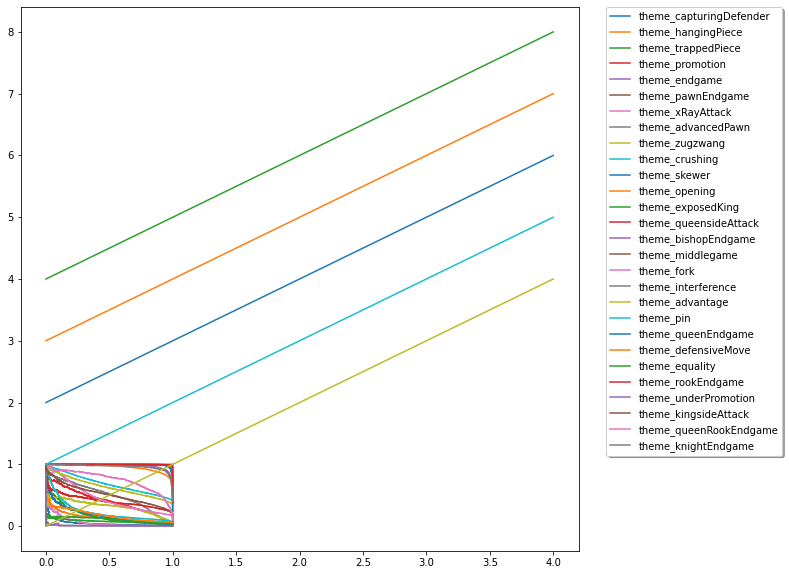

In [19]:
from cycler import cycler

total_precision_list = []
total_auroc_list = []
max_f1_list = []

plt.figure(figsize=(10, 10))

for i in range(y_pred.shape[1]):
    label_average_precision = metrics.average_precision_score(y_true[:,i], y_pred[:,i])
    label_auroc = metrics.roc_auc_score(y_true[:,i], y_pred[:,i])

    precision, recall, threshold = metrics.precision_recall_curve(y_true[:,i], y_pred[:,i])
    plt.plot(recall, precision, label = chess_validation_set.column_names[i])

    f1 = 2 * precision * recall / (precision + recall)
    max_f1 = max(f1)

    max_f1_list.append(max_f1)
    total_precision_list.append(label_average_precision)
    total_auroc_list.append(label_auroc)

for i in range(5):
    x = range(i,i+5)
    linestyle_cycler = cycler('linestyle',['-','--',':','-.'])
    plt.rc('axes', prop_cycle=linestyle_cycler)
    plt.plot(range(5),x)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fancybox=True, shadow=True)
plt.show()

In [10]:
print(total_precision_list)

[0.04951479140548584, 0.1542157298049885, 0.16924379264814768, 0.40953692520219653, 0.9986818861102427, 0.9991644455889992, 0.06239682411296099, 0.4994902602394598, 0.31891100790725513, 0.6851317416644331, 0.17816173243296443, 0.9521825148795988, 0.11297412716542671, 0.4092197968869024, 0.976679066756752, 0.9967918244830558, 0.4602607505579962, 0.009695700594071877, 0.6326031514126185, 0.235909186275127, 0.9908789375252912, 0.17837687767376537, 0.0783976399011295, 0.9960426286452289, 0.006142210276118221, 0.5148404398716695, 0.747979911927016, 0.9607710227834753]


In [11]:
print(total_auroc_list)


[0.7767906757200868, 0.7324557086453044, 0.841614917994193, 0.9604168160001125, 0.9990587157622182, 0.9999844142051902, 0.8010665893626621, 0.9200893153532337, 0.9906669936931006, 0.7531110101106769, 0.8432675144581089, 0.9968807857694045, 0.8915282599536244, 0.9859069780294538, 0.9997586626608137, 0.9965428966063927, 0.7662505501788519, 0.6792923764643806, 0.7634913322174297, 0.7596957879444927, 0.999916658704848, 0.762085231680863, 0.7656783087785177, 0.9998772876147507, 0.949213133114062, 0.9341682830502122, 0.9978462857355438, 0.9997600134936405]


In [12]:
max_f1_list

[0.10075566750629723,
 0.20908916586768933,
 0.24406528189910978,
 0.4497041420118343,
 0.9842188439023305,
 0.9994164559424237,
 0.14456035767511177,
 0.5197188598203827,
 0.41097256857855363,
 0.6394681841562111,
 0.2563767168083715,
 0.8834294309350714,
 0.2006064847212503,
 0.46848273677541974,
 0.9276504297994269,
 0.9712968035366211,
 0.43472059684025743,
 0.029226505416981605,
 0.6057234554693768,
 0.2673294669980668,
 0.9644913627639154,
 0.26547161758429366,
 0.13887315077116777,
 0.9860382535711403,
 0.06451612903225806,
 0.5235534377127298,
 0.701923076923077,
 0.9194029850746269]

In [13]:
np.mean(y_true, axis=0)

array([8.3149383e-03, 5.1620834e-02, 1.6617004e-02, 1.6784333e-02,
       4.3258914e-01, 1.6539777e-02, 3.5975622e-03, 4.4406403e-02,
       4.5693545e-03, 3.9925218e-01, 2.0780910e-02, 6.1699156e-02,
       1.9390795e-02, 1.3624399e-02, 8.8426666e-03, 5.0571167e-01,
       1.5454072e-01, 4.0416261e-03, 3.3937433e-01, 6.6834852e-02,
       6.7124460e-03, 4.9728736e-02, 2.8143361e-02, 3.9714769e-02,
       1.2871421e-04, 7.6990403e-02, 5.9337253e-03, 6.3263034e-03],
      dtype=float32)

In [14]:
np.mean(total_precision_list), np.mean(total_auroc_list)

(0.4922926758832992, 0.8880862679750775)

In [15]:
from functools import reduce

average_precision = reduce(lambda x, y: x+y, average_precision_list) / len(average_precision_list)
print(average_precision)

NameError: name 'average_precision_list' is not defined

In [11]:
final_acc = 0
train_corrects = 0

for batch in tqdm(train_dataloader):
    X = batch['board'].cuda()

    pred = net(X)
    boolean_pred = (pred>0).float()
    train_corrects += (boolean_pred == batch['themes'].cuda()).float().sum()


100%|██████████| 2428/2428 [00:54<00:00, 44.80it/s]


In [12]:
print(correct.item())
print(train_corrects.item())

3989424.0
15961041.0


In [13]:
print(len(validation_dataloader.dataset))
print(len(train_dataloader.dataset))

155383
621532


In [14]:
acc = correct.item()/(len(validation_dataloader.dataset) * 28)
print(acc)

0.916956350253429


In [15]:
acc = train_corrects.item()/(len(train_dataloader.dataset) * 28)
print(acc)

0.9171485596420274
